In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf

%matplotlib inline
plt.style.use('ggplot')

In [2]:
def read_data(file_path):
    column_names = ['user-id','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
    data = pd.read_csv(file_path,header = None, names = column_names)
    return data

def feature_normalize(dataset):
    mu = np.mean(dataset,axis = 0)
    sigma = np.std(dataset,axis = 0)
    return (dataset - mu)/sigma

In [3]:
def plot_axis(ax, x, y, title):
    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)


#create
def plot_subject(subject,data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows = 3, figsize = (15, 10), sharex = True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'x-axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'y-axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(subject)
    plt.subplots_adjust(top=0.90)
    plt.show()
    
    
def windows(data, size):
    start = 0
    while start < data.count():
        yield int(start), int(start + size)
        start += (size / 2)

def segment_signal(data,window_size = 90):
    segments = np.empty((0,window_size,3))
    labels = np.empty((0))
    for (start, end) in windows(data['timestamp'], window_size):
        x = data["x-axis"][start:end]
        y = data["y-axis"][start:end]
        z = data["z-axis"][start:end]
        if(len(dataset['timestamp'][start:end]) == window_size):
            segments = np.vstack([segments,np.dstack([x,y,z])])
            labels = np.append(labels,stats.mode(data["user-id"][start:end])[0][0])
    return segments, labels

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.0, shape = shape)
    return tf.Variable(initial)

def depthwise_conv2d(x, W):
    return tf.nn.depthwise_conv2d(x,W, [1, 1, 1, 1], padding='VALID')

def apply_depthwise_conv(x,kernel_size,num_channels,depth):
    weights = weight_variable([1, kernel_size, num_channels, depth])
    biases = bias_variable([depth * num_channels])
    return tf.nn.relu(tf.add(depthwise_conv2d(x, weights),biases))
    
def apply_max_pool(x,kernel_size,stride_size):
    return tf.nn.max_pool(x, ksize=[1, 1, kernel_size, 1], 
                          strides=[1, 1, stride_size, 1], padding='VALID')

In [4]:
dataset = read_data('/home/deepstation/PRMLlab/technicakidz/Data/ABHI-MWS/acc_raw.csv')
#dataset = dataset.replace("\t",",",regex=True)#.replace(';',',')
dataset.shape

(64955, 6)

In [5]:
dataset[:1]

,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,1.0,flat,1.414656e+09,0.397049,-0.468597,-0.723389


In [6]:
dataset['x-axis'] = feature_normalize(dataset['x-axis'])
dataset['y-axis'] = feature_normalize(dataset['y-axis'])
dataset['z-axis'] = feature_normalize(dataset['z-axis'])

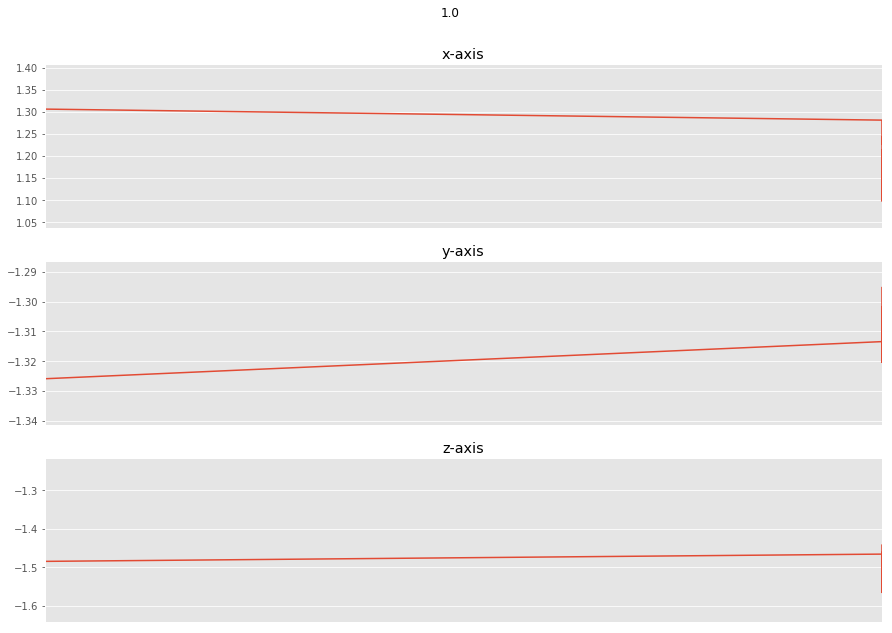

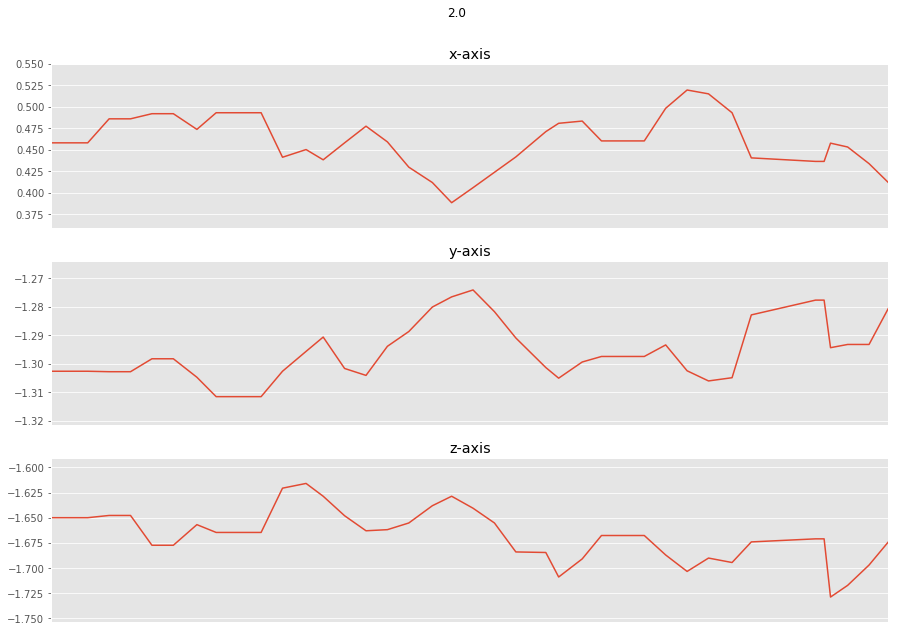

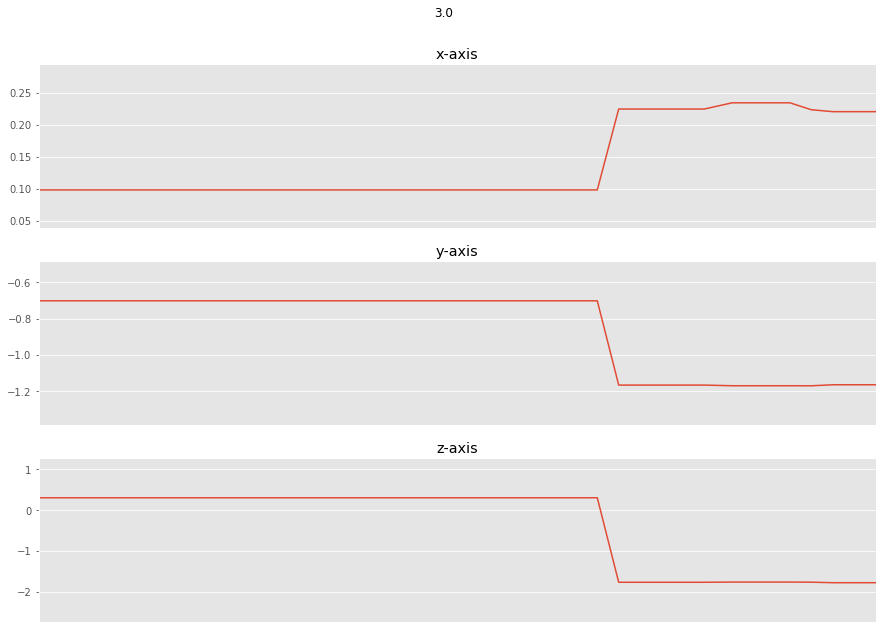

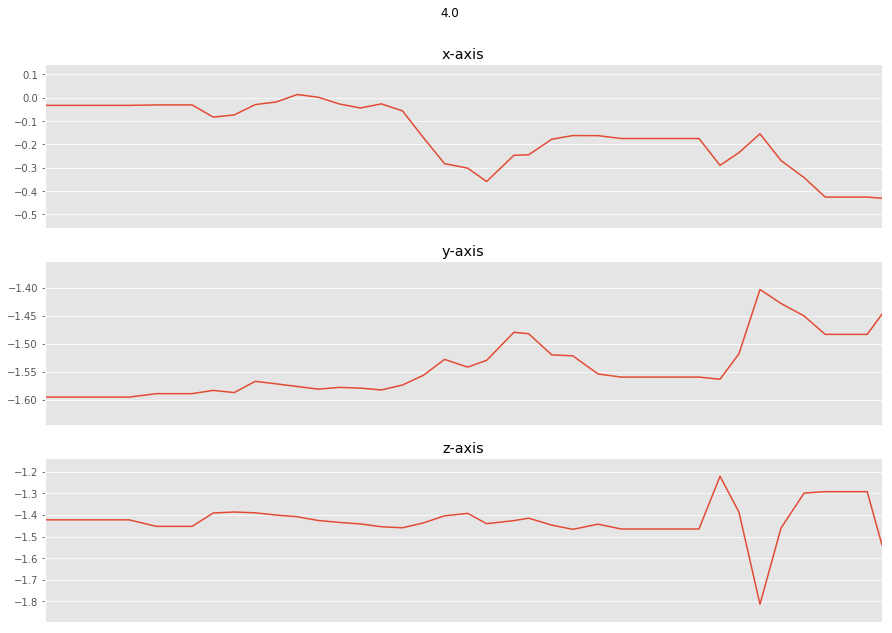

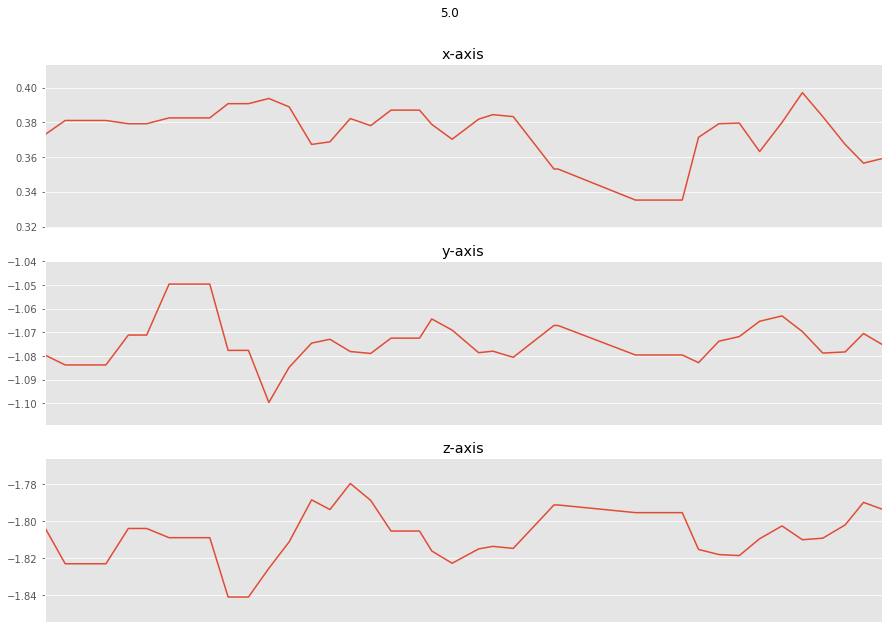

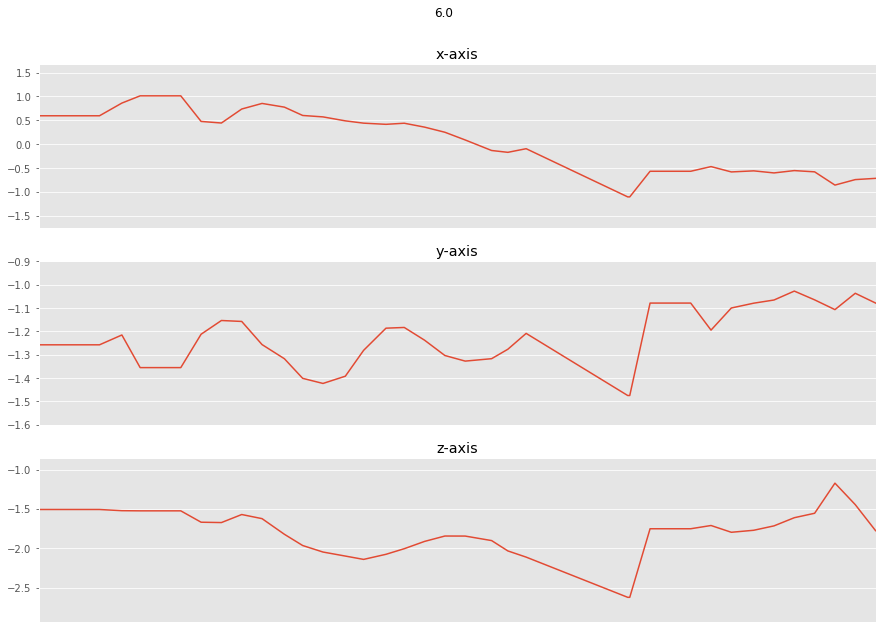

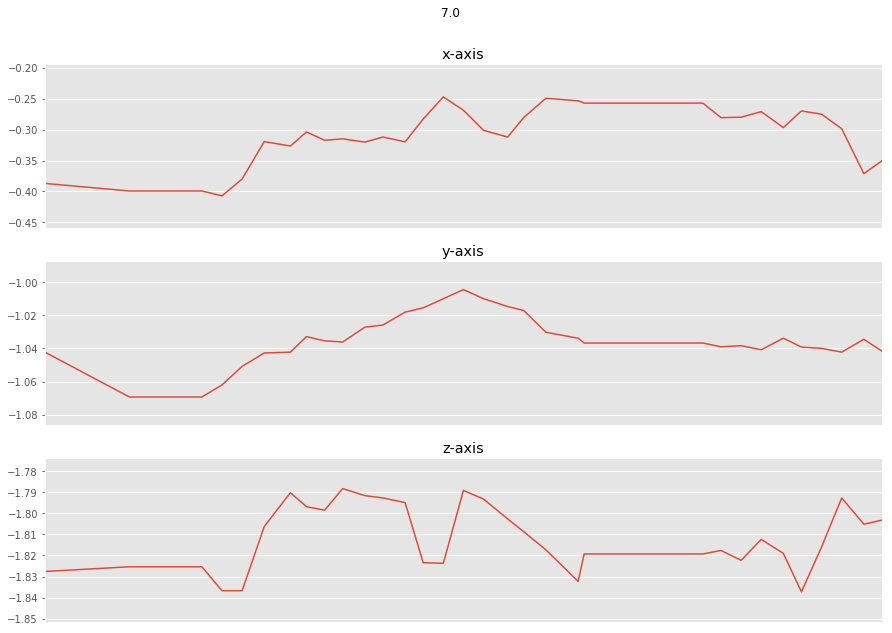

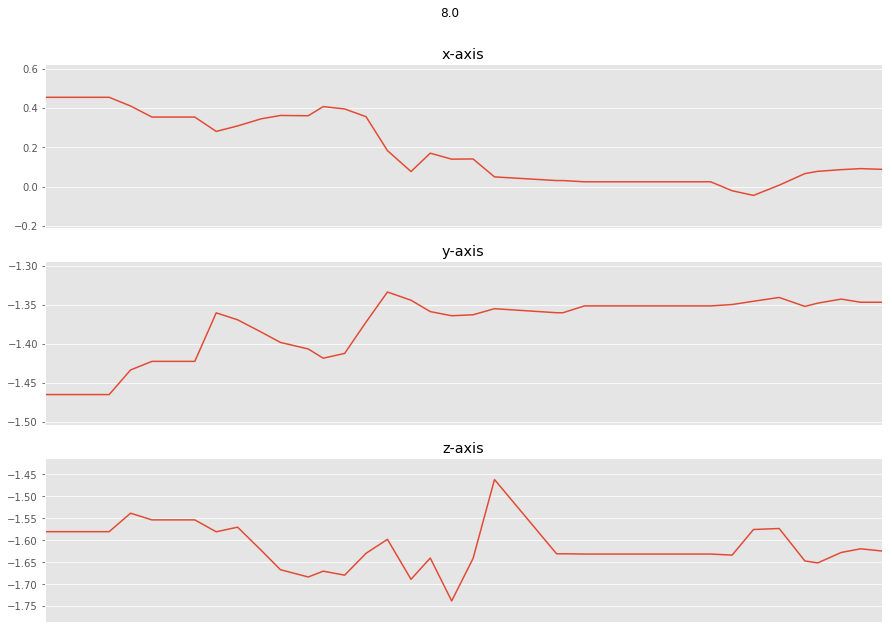

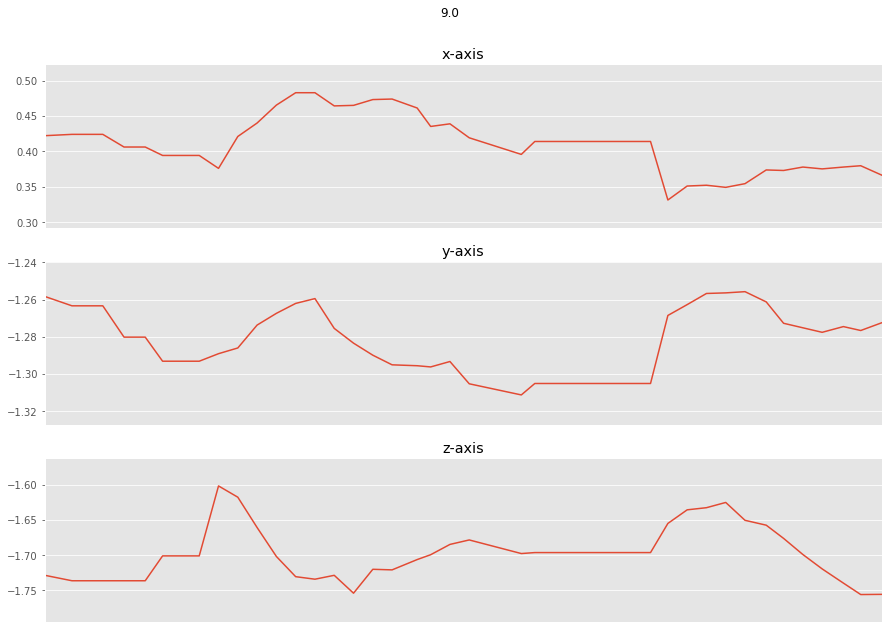

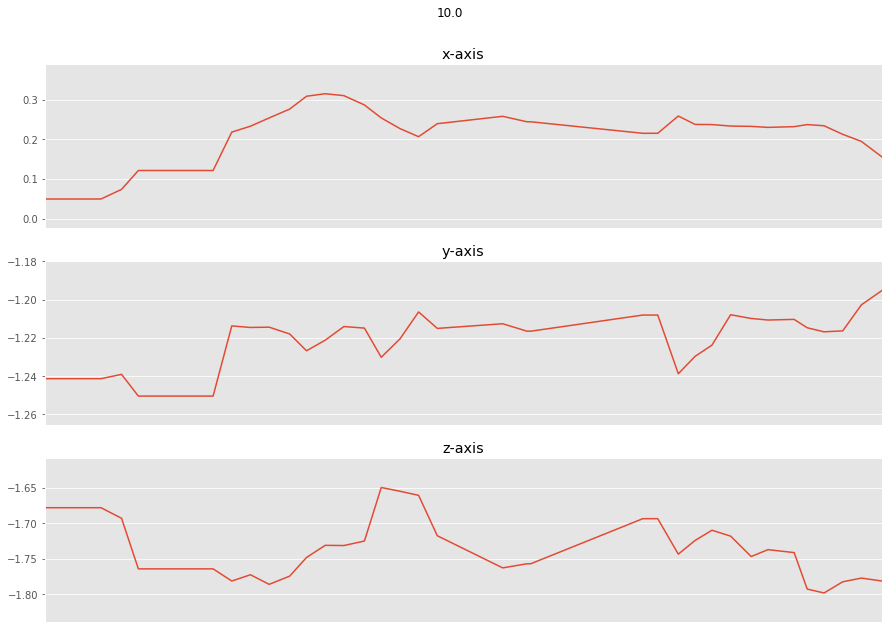

ValueError: min() arg is an empty sequence

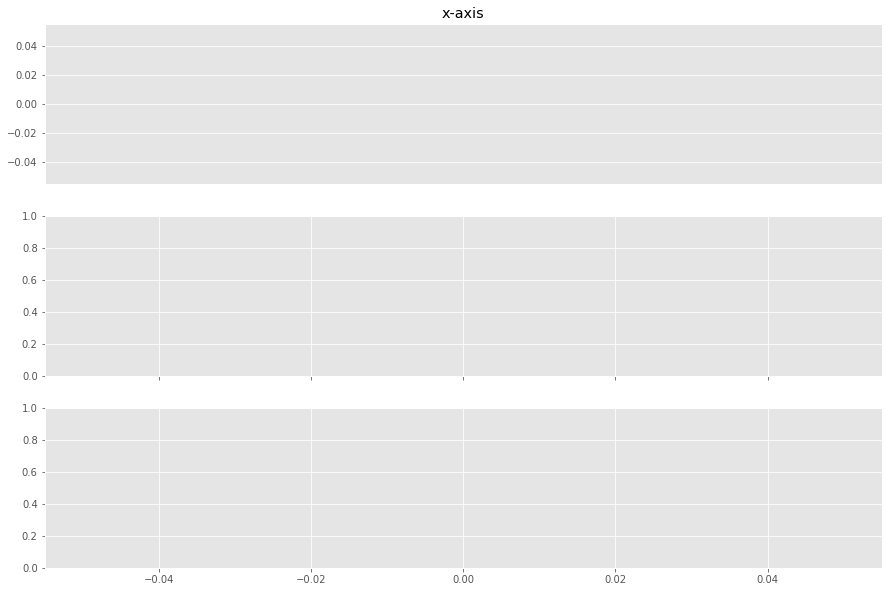

In [7]:
#modify taerget(user-id)
for subject in np.unique(dataset["user-id"]):
    subset = dataset[dataset["user-id"] == subject][:40]
    plot_subject(subject,subset)

In [9]:
segments, labels = segment_signal(dataset)
labels = np.asarray(pd.get_dummies(labels), dtype = np.int8)
reshaped_segments = segments.reshape(len(segments), 1,90, 3)

In [10]:
train_test_split = np.random.rand(len(reshaped_segments)) < 0.70

train_x = reshaped_segments[train_test_split]
train_y = labels[train_test_split]
test_x = reshaped_segments[~train_test_split]
test_y = labels[~train_test_split]

In [11]:
#saved data
np.save('train_x.npy',train_x)
np.save('train_y.npy',train_y)
np.save('test_x.npy',test_x)
np.save('test_y.npy',test_y)

In [12]:
import numpy as np
train_x = np.load('train_x.npy')
train_y = np.load('train_y.npy')
test_x = np.load('test_x.npy')
test_y = np.load('test_y.npy')

In [ ]:
#all acitivity
input_height = 1
input_width = 90
num_labels = 10 #number of users
num_channels = 3

batch_size = 10
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-7
training_epochs = 10000

total_batches = train_x.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
        with tf.name_scope('summary'):
            tf.summary.scalar('loss', loss)
            merged = tf.summary.merge_all()
            writer = tf.summary.FileWriter('./logs', session.graph)
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Epoch:  0  Training Loss:  23.0292  Training Accuracy:  0.103042
Epoch:  1  Training Loss:  23.0314  Training Accuracy:  0.1158
Epoch:  2  Training Loss:  23.0339  Training Accuracy:  0.1158
Epoch:  3  Training Loss:  23.0364  Training Accuracy:  0.1158
Epoch:  4  Training Loss:  23.0389  Training Accuracy:  0.1158
Epoch:  5  Training Loss:  23.0414  Training Accuracy:  0.1158
Epoch:  6  Training Loss:  23.0438  Training Accuracy:  0.1158
Epoch:  7  Training Loss:  23.0463  Training Accuracy:  0.1158
Epoch:  8  Training Loss:  23.0488  Training Accuracy:  0.1158
Epoch:  9  Training Loss:  23.0513  Training Accuracy:  0.1158
Epoch:  10  Training Loss:  23.0537  Training Accuracy:  0.1158
Epoch:  11  Training Loss:  23.0562  Training Accuracy:  0.1158
Epoch:  12  Training Loss:  23.0587  Training Accuracy:  0.1158
Epoch:  13  Training Loss:  23.0612  Training Accuracy:  0.1158
Epoch:  14  Training Loss:  23.0636  Training Accuracy:  0.1158
Epoch:  15  Training Loss:  23.0661  Training Ac

Epoch:  125  Training Loss:  23.3202  Training Accuracy:  0.122669
Epoch:  126  Training Loss:  23.3224  Training Accuracy:  0.122669
Epoch:  127  Training Loss:  23.3245  Training Accuracy:  0.122669
Epoch:  128  Training Loss:  23.3267  Training Accuracy:  0.122669
Epoch:  129  Training Loss:  23.3289  Training Accuracy:  0.122669
Epoch:  130  Training Loss:  23.331  Training Accuracy:  0.122669
Epoch:  131  Training Loss:  23.3332  Training Accuracy:  0.122669
Epoch:  132  Training Loss:  23.3353  Training Accuracy:  0.122669
Epoch:  133  Training Loss:  23.3375  Training Accuracy:  0.122669
Epoch:  134  Training Loss:  23.3396  Training Accuracy:  0.122669
Epoch:  135  Training Loss:  23.3418  Training Accuracy:  0.122669
Epoch:  136  Training Loss:  23.3439  Training Accuracy:  0.122669
Epoch:  137  Training Loss:  23.346  Training Accuracy:  0.122669
Epoch:  138  Training Loss:  23.3482  Training Accuracy:  0.122669
Epoch:  139  Training Loss:  23.3503  Training Accuracy:  0.1226

Epoch:  248  Training Loss:  23.5694  Training Accuracy:  0.122669
Epoch:  249  Training Loss:  23.5712  Training Accuracy:  0.122669
Epoch:  250  Training Loss:  23.5731  Training Accuracy:  0.122669
Epoch:  251  Training Loss:  23.575  Training Accuracy:  0.122669
Epoch:  252  Training Loss:  23.5769  Training Accuracy:  0.122669
Epoch:  253  Training Loss:  23.5788  Training Accuracy:  0.122669
Epoch:  254  Training Loss:  23.5807  Training Accuracy:  0.122669
Epoch:  255  Training Loss:  23.5825  Training Accuracy:  0.122669
Epoch:  256  Training Loss:  23.5844  Training Accuracy:  0.122669
Epoch:  257  Training Loss:  23.5863  Training Accuracy:  0.122669
Epoch:  258  Training Loss:  23.5881  Training Accuracy:  0.122669
Epoch:  259  Training Loss:  23.59  Training Accuracy:  0.122669
Epoch:  260  Training Loss:  23.5919  Training Accuracy:  0.122669
Epoch:  261  Training Loss:  23.5937  Training Accuracy:  0.122669
Epoch:  262  Training Loss:  23.5956  Training Accuracy:  0.12266

Epoch:  371  Training Loss:  23.7868  Training Accuracy:  0.122669
Epoch:  372  Training Loss:  23.7885  Training Accuracy:  0.122669
Epoch:  373  Training Loss:  23.7901  Training Accuracy:  0.122669
Epoch:  374  Training Loss:  23.7918  Training Accuracy:  0.122669
Epoch:  375  Training Loss:  23.7934  Training Accuracy:  0.122669
Epoch:  376  Training Loss:  23.7951  Training Accuracy:  0.122669
Epoch:  377  Training Loss:  23.7967  Training Accuracy:  0.122669
Epoch:  378  Training Loss:  23.7984  Training Accuracy:  0.122669
Epoch:  379  Training Loss:  23.8  Training Accuracy:  0.122669
Epoch:  380  Training Loss:  23.8016  Training Accuracy:  0.122669
Epoch:  381  Training Loss:  23.8033  Training Accuracy:  0.122669
Epoch:  382  Training Loss:  23.8049  Training Accuracy:  0.122669
Epoch:  383  Training Loss:  23.8065  Training Accuracy:  0.122669
Epoch:  384  Training Loss:  23.8082  Training Accuracy:  0.122669
Epoch:  385  Training Loss:  23.8098  Training Accuracy:  0.12266

Epoch:  494  Training Loss:  23.9772  Training Accuracy:  0.122669
Epoch:  495  Training Loss:  23.9787  Training Accuracy:  0.122669
Epoch:  496  Training Loss:  23.9801  Training Accuracy:  0.122669
Epoch:  497  Training Loss:  23.9816  Training Accuracy:  0.122669
Epoch:  498  Training Loss:  23.983  Training Accuracy:  0.122669
Epoch:  499  Training Loss:  23.9845  Training Accuracy:  0.122669
Epoch:  500  Training Loss:  23.9859  Training Accuracy:  0.122669
Epoch:  501  Training Loss:  23.9873  Training Accuracy:  0.122669
Epoch:  502  Training Loss:  23.9888  Training Accuracy:  0.122669
Epoch:  503  Training Loss:  23.9902  Training Accuracy:  0.122669
Epoch:  504  Training Loss:  23.9916  Training Accuracy:  0.122669
Epoch:  505  Training Loss:  23.9931  Training Accuracy:  0.122669
Epoch:  506  Training Loss:  23.9945  Training Accuracy:  0.122669
Epoch:  507  Training Loss:  23.9959  Training Accuracy:  0.122669
Epoch:  508  Training Loss:  23.9974  Training Accuracy:  0.122

Epoch:  617  Training Loss:  24.1446  Training Accuracy:  0.122669
Epoch:  618  Training Loss:  24.1458  Training Accuracy:  0.122669
Epoch:  619  Training Loss:  24.1471  Training Accuracy:  0.122669
Epoch:  620  Training Loss:  24.1484  Training Accuracy:  0.122669
Epoch:  621  Training Loss:  24.1497  Training Accuracy:  0.122669
Epoch:  622  Training Loss:  24.1509  Training Accuracy:  0.122669
Epoch:  623  Training Loss:  24.1522  Training Accuracy:  0.122669
Epoch:  624  Training Loss:  24.1535  Training Accuracy:  0.122669
Epoch:  625  Training Loss:  24.1547  Training Accuracy:  0.122669
Epoch:  626  Training Loss:  24.156  Training Accuracy:  0.122669
Epoch:  627  Training Loss:  24.1573  Training Accuracy:  0.122669
Epoch:  628  Training Loss:  24.1585  Training Accuracy:  0.122669
Epoch:  629  Training Loss:  24.1598  Training Accuracy:  0.122669
Epoch:  630  Training Loss:  24.161  Training Accuracy:  0.122669
Epoch:  631  Training Loss:  24.1623  Training Accuracy:  0.1226

Epoch:  740  Training Loss:  24.2918  Training Accuracy:  0.122669
Epoch:  741  Training Loss:  24.2929  Training Accuracy:  0.122669
Epoch:  742  Training Loss:  24.294  Training Accuracy:  0.122669
Epoch:  743  Training Loss:  24.2952  Training Accuracy:  0.122669
Epoch:  744  Training Loss:  24.2963  Training Accuracy:  0.122669
Epoch:  745  Training Loss:  24.2974  Training Accuracy:  0.122669
Epoch:  746  Training Loss:  24.2985  Training Accuracy:  0.122669
Epoch:  747  Training Loss:  24.2996  Training Accuracy:  0.122669
Epoch:  748  Training Loss:  24.3007  Training Accuracy:  0.122669
Epoch:  749  Training Loss:  24.3019  Training Accuracy:  0.122669
Epoch:  750  Training Loss:  24.303  Training Accuracy:  0.122669
Epoch:  751  Training Loss:  24.3041  Training Accuracy:  0.122669
Epoch:  752  Training Loss:  24.3052  Training Accuracy:  0.122669
Epoch:  753  Training Loss:  24.3063  Training Accuracy:  0.122669
Epoch:  754  Training Loss:  24.3074  Training Accuracy:  0.1226

Epoch:  863  Training Loss:  24.4216  Training Accuracy:  0.122669
Epoch:  864  Training Loss:  24.4226  Training Accuracy:  0.122669
Epoch:  865  Training Loss:  24.4236  Training Accuracy:  0.122669
Epoch:  866  Training Loss:  24.4246  Training Accuracy:  0.122669
Epoch:  867  Training Loss:  24.4255  Training Accuracy:  0.122669
Epoch:  868  Training Loss:  24.4265  Training Accuracy:  0.122669
Epoch:  869  Training Loss:  24.4275  Training Accuracy:  0.122669
Epoch:  870  Training Loss:  24.4285  Training Accuracy:  0.122669
Epoch:  871  Training Loss:  24.4295  Training Accuracy:  0.122669
Epoch:  872  Training Loss:  24.4305  Training Accuracy:  0.122669
Epoch:  873  Training Loss:  24.4314  Training Accuracy:  0.122669
Epoch:  874  Training Loss:  24.4324  Training Accuracy:  0.122669
Epoch:  875  Training Loss:  24.4334  Training Accuracy:  0.122669
Epoch:  876  Training Loss:  24.4344  Training Accuracy:  0.122669
Epoch:  877  Training Loss:  24.4354  Training Accuracy:  0.12

Epoch:  986  Training Loss:  24.5362  Training Accuracy:  0.122669
Epoch:  987  Training Loss:  24.5371  Training Accuracy:  0.122669
Epoch:  988  Training Loss:  24.538  Training Accuracy:  0.122669
Epoch:  989  Training Loss:  24.5388  Training Accuracy:  0.122669
Epoch:  990  Training Loss:  24.5397  Training Accuracy:  0.122669
Epoch:  991  Training Loss:  24.5406  Training Accuracy:  0.122669
Epoch:  992  Training Loss:  24.5414  Training Accuracy:  0.122669
Epoch:  993  Training Loss:  24.5423  Training Accuracy:  0.122669
Epoch:  994  Training Loss:  24.5432  Training Accuracy:  0.122669
Epoch:  995  Training Loss:  24.544  Training Accuracy:  0.122669
Epoch:  996  Training Loss:  24.5449  Training Accuracy:  0.122669
Epoch:  997  Training Loss:  24.5458  Training Accuracy:  0.122669
Epoch:  998  Training Loss:  24.5466  Training Accuracy:  0.122669
Epoch:  999  Training Loss:  24.5475  Training Accuracy:  0.122669
Epoch:  1000  Training Loss:  24.5484  Training Accuracy:  0.122

Epoch:  1107  Training Loss:  24.636  Training Accuracy:  0.122669
Epoch:  1108  Training Loss:  24.6368  Training Accuracy:  0.122669
Epoch:  1109  Training Loss:  24.6376  Training Accuracy:  0.122669
Epoch:  1110  Training Loss:  24.6384  Training Accuracy:  0.122669
Epoch:  1111  Training Loss:  24.6391  Training Accuracy:  0.122669
Epoch:  1112  Training Loss:  24.6399  Training Accuracy:  0.122669
Epoch:  1113  Training Loss:  24.6407  Training Accuracy:  0.122669
Epoch:  1114  Training Loss:  24.6415  Training Accuracy:  0.122669
Epoch:  1115  Training Loss:  24.6422  Training Accuracy:  0.122669
Epoch:  1116  Training Loss:  24.643  Training Accuracy:  0.122669
Epoch:  1117  Training Loss:  24.6438  Training Accuracy:  0.122669
Epoch:  1118  Training Loss:  24.6445  Training Accuracy:  0.122669
Epoch:  1119  Training Loss:  24.6453  Training Accuracy:  0.122669
Epoch:  1120  Training Loss:  24.6461  Training Accuracy:  0.122669
Epoch:  1121  Training Loss:  24.6468  Training Ac

Epoch:  1228  Training Loss:  24.7247  Training Accuracy:  0.122669
Epoch:  1229  Training Loss:  24.7254  Training Accuracy:  0.122669
Epoch:  1230  Training Loss:  24.726  Training Accuracy:  0.122669
Epoch:  1231  Training Loss:  24.7267  Training Accuracy:  0.122669
Epoch:  1232  Training Loss:  24.7274  Training Accuracy:  0.122669
Epoch:  1233  Training Loss:  24.7281  Training Accuracy:  0.122669
Epoch:  1234  Training Loss:  24.7288  Training Accuracy:  0.122669
Epoch:  1235  Training Loss:  24.7295  Training Accuracy:  0.122669
Epoch:  1236  Training Loss:  24.7302  Training Accuracy:  0.122669
Epoch:  1237  Training Loss:  24.7308  Training Accuracy:  0.122669
Epoch:  1238  Training Loss:  24.7315  Training Accuracy:  0.122669
Epoch:  1239  Training Loss:  24.7322  Training Accuracy:  0.122669
Epoch:  1240  Training Loss:  24.7329  Training Accuracy:  0.122669
Epoch:  1241  Training Loss:  24.7336  Training Accuracy:  0.122669
Epoch:  1242  Training Loss:  24.7343  Training A

Epoch:  1349  Training Loss:  24.8034  Training Accuracy:  0.122669
Epoch:  1350  Training Loss:  24.8041  Training Accuracy:  0.122669
Epoch:  1351  Training Loss:  24.8047  Training Accuracy:  0.122669
Epoch:  1352  Training Loss:  24.8053  Training Accuracy:  0.122669
Epoch:  1353  Training Loss:  24.8059  Training Accuracy:  0.122669
Epoch:  1354  Training Loss:  24.8065  Training Accuracy:  0.122669
Epoch:  1355  Training Loss:  24.8071  Training Accuracy:  0.122669
Epoch:  1356  Training Loss:  24.8077  Training Accuracy:  0.122669
Epoch:  1357  Training Loss:  24.8083  Training Accuracy:  0.122669
Epoch:  1358  Training Loss:  24.8089  Training Accuracy:  0.122669
Epoch:  1359  Training Loss:  24.8095  Training Accuracy:  0.122669
Epoch:  1360  Training Loss:  24.8102  Training Accuracy:  0.122669
Epoch:  1361  Training Loss:  24.8108  Training Accuracy:  0.122669
Epoch:  1362  Training Loss:  24.8114  Training Accuracy:  0.122669
Epoch:  1363  Training Loss:  24.812  Training A

Epoch:  1470  Training Loss:  24.8735  Training Accuracy:  0.122669
Epoch:  1471  Training Loss:  24.8741  Training Accuracy:  0.122669
Epoch:  1472  Training Loss:  24.8746  Training Accuracy:  0.122669
Epoch:  1473  Training Loss:  24.8752  Training Accuracy:  0.122669
Epoch:  1474  Training Loss:  24.8757  Training Accuracy:  0.122669
Epoch:  1475  Training Loss:  24.8763  Training Accuracy:  0.122669
Epoch:  1476  Training Loss:  24.8768  Training Accuracy:  0.122669
Epoch:  1477  Training Loss:  24.8774  Training Accuracy:  0.122669
Epoch:  1478  Training Loss:  24.8779  Training Accuracy:  0.122669
Epoch:  1479  Training Loss:  24.8784  Training Accuracy:  0.122669
Epoch:  1480  Training Loss:  24.879  Training Accuracy:  0.122669
Epoch:  1481  Training Loss:  24.8795  Training Accuracy:  0.122669
Epoch:  1482  Training Loss:  24.8801  Training Accuracy:  0.122669
Epoch:  1483  Training Loss:  24.8806  Training Accuracy:  0.122669
Epoch:  1484  Training Loss:  24.8811  Training A

Epoch:  1591  Training Loss:  24.936  Training Accuracy:  0.122669
Epoch:  1592  Training Loss:  24.9365  Training Accuracy:  0.122669
Epoch:  1593  Training Loss:  24.937  Training Accuracy:  0.122669
Epoch:  1594  Training Loss:  24.9375  Training Accuracy:  0.122669
Epoch:  1595  Training Loss:  24.938  Training Accuracy:  0.122669
Epoch:  1596  Training Loss:  24.9384  Training Accuracy:  0.122669
Epoch:  1597  Training Loss:  24.9389  Training Accuracy:  0.122669
Epoch:  1598  Training Loss:  24.9394  Training Accuracy:  0.122669
Epoch:  1599  Training Loss:  24.9399  Training Accuracy:  0.122669
Epoch:  1600  Training Loss:  24.9404  Training Accuracy:  0.122669
Epoch:  1601  Training Loss:  24.9409  Training Accuracy:  0.122669
Epoch:  1602  Training Loss:  24.9414  Training Accuracy:  0.122669
Epoch:  1603  Training Loss:  24.9418  Training Accuracy:  0.122669
Epoch:  1604  Training Loss:  24.9423  Training Accuracy:  0.122669
Epoch:  1605  Training Loss:  24.9428  Training Acc

Epoch:  1712  Training Loss:  24.9917  Training Accuracy:  0.122669
Epoch:  1713  Training Loss:  24.9922  Training Accuracy:  0.122669
Epoch:  1714  Training Loss:  24.9926  Training Accuracy:  0.122669
Epoch:  1715  Training Loss:  24.9931  Training Accuracy:  0.122669
Epoch:  1716  Training Loss:  24.9935  Training Accuracy:  0.122669
Epoch:  1717  Training Loss:  24.9939  Training Accuracy:  0.122669
Epoch:  1718  Training Loss:  24.9943  Training Accuracy:  0.122669
Epoch:  1719  Training Loss:  24.9948  Training Accuracy:  0.122669
Epoch:  1720  Training Loss:  24.9952  Training Accuracy:  0.122669
Epoch:  1721  Training Loss:  24.9956  Training Accuracy:  0.122669
Epoch:  1722  Training Loss:  24.9961  Training Accuracy:  0.122669
Epoch:  1723  Training Loss:  24.9965  Training Accuracy:  0.122669
Epoch:  1724  Training Loss:  24.9969  Training Accuracy:  0.122669
Epoch:  1725  Training Loss:  24.9974  Training Accuracy:  0.122669
Epoch:  1726  Training Loss:  24.9978  Training 

Epoch:  1833  Training Loss:  25.0415  Training Accuracy:  0.122669
Epoch:  1834  Training Loss:  25.0419  Training Accuracy:  0.122669
Epoch:  1835  Training Loss:  25.0423  Training Accuracy:  0.122669
Epoch:  1836  Training Loss:  25.0427  Training Accuracy:  0.122669
Epoch:  1837  Training Loss:  25.043  Training Accuracy:  0.122669
Epoch:  1838  Training Loss:  25.0434  Training Accuracy:  0.122669
Epoch:  1839  Training Loss:  25.0438  Training Accuracy:  0.122669
Epoch:  1840  Training Loss:  25.0442  Training Accuracy:  0.122669
Epoch:  1841  Training Loss:  25.0446  Training Accuracy:  0.122669
Epoch:  1842  Training Loss:  25.045  Training Accuracy:  0.122669
Epoch:  1843  Training Loss:  25.0454  Training Accuracy:  0.122669
Epoch:  1844  Training Loss:  25.0457  Training Accuracy:  0.122669
Epoch:  1845  Training Loss:  25.0461  Training Accuracy:  0.122669
Epoch:  1846  Training Loss:  25.0465  Training Accuracy:  0.122669
Epoch:  1847  Training Loss:  25.0469  Training Ac

Epoch:  1954  Training Loss:  25.086  Training Accuracy:  0.122669
Epoch:  1955  Training Loss:  25.0863  Training Accuracy:  0.122669
Epoch:  1956  Training Loss:  25.0867  Training Accuracy:  0.122669
Epoch:  1957  Training Loss:  25.087  Training Accuracy:  0.122669
Epoch:  1958  Training Loss:  25.0873  Training Accuracy:  0.122669
Epoch:  1959  Training Loss:  25.0877  Training Accuracy:  0.122669
Epoch:  1960  Training Loss:  25.088  Training Accuracy:  0.122669
Epoch:  1961  Training Loss:  25.0884  Training Accuracy:  0.122669
Epoch:  1962  Training Loss:  25.0887  Training Accuracy:  0.122669
Epoch:  1963  Training Loss:  25.0891  Training Accuracy:  0.122669
Epoch:  1964  Training Loss:  25.0894  Training Accuracy:  0.122669
Epoch:  1965  Training Loss:  25.0898  Training Accuracy:  0.122669
Epoch:  1966  Training Loss:  25.0901  Training Accuracy:  0.122669
Epoch:  1967  Training Loss:  25.0904  Training Accuracy:  0.122669
Epoch:  1968  Training Loss:  25.0908  Training Acc

Epoch:  2075  Training Loss:  25.1257  Training Accuracy:  0.122669
Epoch:  2076  Training Loss:  25.1261  Training Accuracy:  0.122669
Epoch:  2077  Training Loss:  25.1264  Training Accuracy:  0.122669
Epoch:  2078  Training Loss:  25.1267  Training Accuracy:  0.122669
Epoch:  2079  Training Loss:  25.127  Training Accuracy:  0.122669
Epoch:  2080  Training Loss:  25.1273  Training Accuracy:  0.122669
Epoch:  2081  Training Loss:  25.1276  Training Accuracy:  0.122669
Epoch:  2082  Training Loss:  25.1279  Training Accuracy:  0.122669
Epoch:  2083  Training Loss:  25.1282  Training Accuracy:  0.122669
Epoch:  2084  Training Loss:  25.1285  Training Accuracy:  0.122669
Epoch:  2085  Training Loss:  25.1288  Training Accuracy:  0.122669
Epoch:  2086  Training Loss:  25.1292  Training Accuracy:  0.122669
Epoch:  2087  Training Loss:  25.1295  Training Accuracy:  0.122669
Epoch:  2088  Training Loss:  25.1298  Training Accuracy:  0.122669
Epoch:  2089  Training Loss:  25.1301  Training A

Epoch:  2196  Training Loss:  25.1614  Training Accuracy:  0.122669
Epoch:  2197  Training Loss:  25.1616  Training Accuracy:  0.122669
Epoch:  2198  Training Loss:  25.1619  Training Accuracy:  0.122669
Epoch:  2199  Training Loss:  25.1622  Training Accuracy:  0.122669
Epoch:  2200  Training Loss:  25.1625  Training Accuracy:  0.122669
Epoch:  2201  Training Loss:  25.1628  Training Accuracy:  0.122669
Epoch:  2202  Training Loss:  25.163  Training Accuracy:  0.122669
Epoch:  2203  Training Loss:  25.1633  Training Accuracy:  0.122669
Epoch:  2204  Training Loss:  25.1636  Training Accuracy:  0.122669
Epoch:  2205  Training Loss:  25.1639  Training Accuracy:  0.122669
Epoch:  2206  Training Loss:  25.1641  Training Accuracy:  0.122669
Epoch:  2207  Training Loss:  25.1644  Training Accuracy:  0.122669
Epoch:  2208  Training Loss:  25.1647  Training Accuracy:  0.122669
Epoch:  2209  Training Loss:  25.165  Training Accuracy:  0.122669
Epoch:  2210  Training Loss:  25.1652  Training Ac

Epoch:  2317  Training Loss:  25.1933  Training Accuracy:  0.122669
Epoch:  2318  Training Loss:  25.1935  Training Accuracy:  0.122669
Epoch:  2319  Training Loss:  25.1938  Training Accuracy:  0.122669
Epoch:  2320  Training Loss:  25.194  Training Accuracy:  0.122669
Epoch:  2321  Training Loss:  25.1943  Training Accuracy:  0.122669
Epoch:  2322  Training Loss:  25.1945  Training Accuracy:  0.122669
Epoch:  2323  Training Loss:  25.1948  Training Accuracy:  0.122669
Epoch:  2324  Training Loss:  25.195  Training Accuracy:  0.122669
Epoch:  2325  Training Loss:  25.1953  Training Accuracy:  0.122669
Epoch:  2326  Training Loss:  25.1955  Training Accuracy:  0.122669
Epoch:  2327  Training Loss:  25.1957  Training Accuracy:  0.122669
Epoch:  2328  Training Loss:  25.196  Training Accuracy:  0.122669
Epoch:  2329  Training Loss:  25.1962  Training Accuracy:  0.122669
Epoch:  2330  Training Loss:  25.1965  Training Accuracy:  0.122669
Epoch:  2331  Training Loss:  25.1967  Training Acc

Epoch:  2438  Training Loss:  25.2219  Training Accuracy:  0.122669
Epoch:  2439  Training Loss:  25.2221  Training Accuracy:  0.122669
Epoch:  2440  Training Loss:  25.2223  Training Accuracy:  0.122669
Epoch:  2441  Training Loss:  25.2225  Training Accuracy:  0.122669
Epoch:  2442  Training Loss:  25.2227  Training Accuracy:  0.122669
Epoch:  2443  Training Loss:  25.223  Training Accuracy:  0.122669
Epoch:  2444  Training Loss:  25.2232  Training Accuracy:  0.122669
Epoch:  2445  Training Loss:  25.2234  Training Accuracy:  0.122669
Epoch:  2446  Training Loss:  25.2236  Training Accuracy:  0.122669
Epoch:  2447  Training Loss:  25.2239  Training Accuracy:  0.122669
Epoch:  2448  Training Loss:  25.2241  Training Accuracy:  0.122669
Epoch:  2449  Training Loss:  25.2243  Training Accuracy:  0.122669
Epoch:  2450  Training Loss:  25.2245  Training Accuracy:  0.122669
Epoch:  2451  Training Loss:  25.2247  Training Accuracy:  0.122669
Epoch:  2452  Training Loss:  25.225  Training Ac

Epoch:  2559  Training Loss:  25.2475  Training Accuracy:  0.122669
Epoch:  2560  Training Loss:  25.2477  Training Accuracy:  0.122669
Epoch:  2561  Training Loss:  25.2479  Training Accuracy:  0.122669
Epoch:  2562  Training Loss:  25.2481  Training Accuracy:  0.122669
Epoch:  2563  Training Loss:  25.2483  Training Accuracy:  0.122669
Epoch:  2564  Training Loss:  25.2485  Training Accuracy:  0.122669
Epoch:  2565  Training Loss:  25.2487  Training Accuracy:  0.122669
Epoch:  2566  Training Loss:  25.2489  Training Accuracy:  0.122669
Epoch:  2567  Training Loss:  25.2491  Training Accuracy:  0.122669
Epoch:  2568  Training Loss:  25.2493  Training Accuracy:  0.122669
Epoch:  2569  Training Loss:  25.2495  Training Accuracy:  0.122669
Epoch:  2570  Training Loss:  25.2497  Training Accuracy:  0.122669
Epoch:  2571  Training Loss:  25.2499  Training Accuracy:  0.122669
Epoch:  2572  Training Loss:  25.2501  Training Accuracy:  0.122669
Epoch:  2573  Training Loss:  25.2503  Training 

Epoch:  2680  Training Loss:  25.2705  Training Accuracy:  0.122669
Epoch:  2681  Training Loss:  25.2707  Training Accuracy:  0.122669
Epoch:  2682  Training Loss:  25.2709  Training Accuracy:  0.122669
Epoch:  2683  Training Loss:  25.271  Training Accuracy:  0.122669
Epoch:  2684  Training Loss:  25.2712  Training Accuracy:  0.122669
Epoch:  2685  Training Loss:  25.2714  Training Accuracy:  0.122669
Epoch:  2686  Training Loss:  25.2716  Training Accuracy:  0.122669
Epoch:  2687  Training Loss:  25.2718  Training Accuracy:  0.122669
Epoch:  2688  Training Loss:  25.2719  Training Accuracy:  0.122669
Epoch:  2689  Training Loss:  25.2721  Training Accuracy:  0.122669
Epoch:  2690  Training Loss:  25.2723  Training Accuracy:  0.122669
Epoch:  2691  Training Loss:  25.2725  Training Accuracy:  0.122669
Epoch:  2692  Training Loss:  25.2726  Training Accuracy:  0.122669
Epoch:  2693  Training Loss:  25.2728  Training Accuracy:  0.122669
Epoch:  2694  Training Loss:  25.273  Training Ac

Epoch:  2801  Training Loss:  25.2912  Training Accuracy:  0.122669
Epoch:  2802  Training Loss:  25.2913  Training Accuracy:  0.122669
Epoch:  2803  Training Loss:  25.2915  Training Accuracy:  0.122669
Epoch:  2804  Training Loss:  25.2916  Training Accuracy:  0.122669
Epoch:  2805  Training Loss:  25.2918  Training Accuracy:  0.122669
Epoch:  2806  Training Loss:  25.292  Training Accuracy:  0.122669
Epoch:  2807  Training Loss:  25.2921  Training Accuracy:  0.122669
Epoch:  2808  Training Loss:  25.2923  Training Accuracy:  0.122669
Epoch:  2809  Training Loss:  25.2924  Training Accuracy:  0.122669
Epoch:  2810  Training Loss:  25.2926  Training Accuracy:  0.122669
Epoch:  2811  Training Loss:  25.2928  Training Accuracy:  0.122669
Epoch:  2812  Training Loss:  25.2929  Training Accuracy:  0.122669
Epoch:  2813  Training Loss:  25.2931  Training Accuracy:  0.122669
Epoch:  2814  Training Loss:  25.2932  Training Accuracy:  0.122669
Epoch:  2815  Training Loss:  25.2934  Training A

Epoch:  2922  Training Loss:  25.3097  Training Accuracy:  0.122669
Epoch:  2923  Training Loss:  25.3098  Training Accuracy:  0.122669
Epoch:  2924  Training Loss:  25.31  Training Accuracy:  0.122669
Epoch:  2925  Training Loss:  25.3101  Training Accuracy:  0.122669
Epoch:  2926  Training Loss:  25.3103  Training Accuracy:  0.122669
Epoch:  2927  Training Loss:  25.3104  Training Accuracy:  0.122669
Epoch:  2928  Training Loss:  25.3106  Training Accuracy:  0.122669
Epoch:  2929  Training Loss:  25.3107  Training Accuracy:  0.122669
Epoch:  2930  Training Loss:  25.3109  Training Accuracy:  0.122669
Epoch:  2931  Training Loss:  25.311  Training Accuracy:  0.122669
Epoch:  2932  Training Loss:  25.3111  Training Accuracy:  0.122669
Epoch:  2933  Training Loss:  25.3113  Training Accuracy:  0.122669
Epoch:  2934  Training Loss:  25.3114  Training Accuracy:  0.122669
Epoch:  2935  Training Loss:  25.3116  Training Accuracy:  0.122669
Epoch:  2936  Training Loss:  25.3117  Training Acc

Epoch:  3043  Training Loss:  25.3264  Training Accuracy:  0.122669
Epoch:  3044  Training Loss:  25.3265  Training Accuracy:  0.122669
Epoch:  3045  Training Loss:  25.3266  Training Accuracy:  0.122669
Epoch:  3046  Training Loss:  25.3268  Training Accuracy:  0.122669
Epoch:  3047  Training Loss:  25.3269  Training Accuracy:  0.122669
Epoch:  3048  Training Loss:  25.327  Training Accuracy:  0.122669
Epoch:  3049  Training Loss:  25.3272  Training Accuracy:  0.122669
Epoch:  3050  Training Loss:  25.3273  Training Accuracy:  0.122669
Epoch:  3051  Training Loss:  25.3274  Training Accuracy:  0.122669
Epoch:  3052  Training Loss:  25.3276  Training Accuracy:  0.122669
Epoch:  3053  Training Loss:  25.3277  Training Accuracy:  0.122669
Epoch:  3054  Training Loss:  25.3278  Training Accuracy:  0.122669
Epoch:  3055  Training Loss:  25.3279  Training Accuracy:  0.122669
Epoch:  3056  Training Loss:  25.3281  Training Accuracy:  0.122669
Epoch:  3057  Training Loss:  25.3282  Training A

Epoch:  3164  Training Loss:  25.3414  Training Accuracy:  0.122669
Epoch:  3165  Training Loss:  25.3415  Training Accuracy:  0.122669
Epoch:  3166  Training Loss:  25.3416  Training Accuracy:  0.122669
Epoch:  3167  Training Loss:  25.3417  Training Accuracy:  0.122669
Epoch:  3168  Training Loss:  25.3418  Training Accuracy:  0.122669
Epoch:  3169  Training Loss:  25.3419  Training Accuracy:  0.122669
Epoch:  3170  Training Loss:  25.3421  Training Accuracy:  0.122669
Epoch:  3171  Training Loss:  25.3422  Training Accuracy:  0.122669
Epoch:  3172  Training Loss:  25.3423  Training Accuracy:  0.122669
Epoch:  3173  Training Loss:  25.3424  Training Accuracy:  0.122669
Epoch:  3174  Training Loss:  25.3425  Training Accuracy:  0.122669
Epoch:  3175  Training Loss:  25.3426  Training Accuracy:  0.122669
Epoch:  3176  Training Loss:  25.3428  Training Accuracy:  0.122669
Epoch:  3177  Training Loss:  25.3429  Training Accuracy:  0.122669
Epoch:  3178  Training Loss:  25.343  Training A

Epoch:  3285  Training Loss:  25.3549  Training Accuracy:  0.122669
Epoch:  3286  Training Loss:  25.355  Training Accuracy:  0.122669
Epoch:  3287  Training Loss:  25.3551  Training Accuracy:  0.122669
Epoch:  3288  Training Loss:  25.3552  Training Accuracy:  0.122669
Epoch:  3289  Training Loss:  25.3553  Training Accuracy:  0.122669
Epoch:  3290  Training Loss:  25.3554  Training Accuracy:  0.122669
Epoch:  3291  Training Loss:  25.3555  Training Accuracy:  0.122669
Epoch:  3292  Training Loss:  25.3556  Training Accuracy:  0.122669
Epoch:  3293  Training Loss:  25.3557  Training Accuracy:  0.122669
Epoch:  3294  Training Loss:  25.3558  Training Accuracy:  0.122669
Epoch:  3295  Training Loss:  25.3559  Training Accuracy:  0.122669
Epoch:  3296  Training Loss:  25.356  Training Accuracy:  0.122669
Epoch:  3297  Training Loss:  25.3561  Training Accuracy:  0.122669
Epoch:  3298  Training Loss:  25.3562  Training Accuracy:  0.122669
Epoch:  3299  Training Loss:  25.3563  Training Ac

Epoch:  3406  Training Loss:  25.367  Training Accuracy:  0.122669
Epoch:  3407  Training Loss:  25.3671  Training Accuracy:  0.122669
Epoch:  3408  Training Loss:  25.3672  Training Accuracy:  0.122669
Epoch:  3409  Training Loss:  25.3673  Training Accuracy:  0.122669
Epoch:  3410  Training Loss:  25.3673  Training Accuracy:  0.122669
Epoch:  3411  Training Loss:  25.3674  Training Accuracy:  0.122669
Epoch:  3412  Training Loss:  25.3675  Training Accuracy:  0.122669
Epoch:  3413  Training Loss:  25.3676  Training Accuracy:  0.122669
Epoch:  3414  Training Loss:  25.3677  Training Accuracy:  0.122669
Epoch:  3415  Training Loss:  25.3678  Training Accuracy:  0.122669
Epoch:  3416  Training Loss:  25.3679  Training Accuracy:  0.122669
Epoch:  3417  Training Loss:  25.368  Training Accuracy:  0.122669
Epoch:  3418  Training Loss:  25.3681  Training Accuracy:  0.122669
Epoch:  3419  Training Loss:  25.3682  Training Accuracy:  0.122669
Epoch:  3420  Training Loss:  25.3683  Training Ac

In [ ]:
#all acitivity
input_height = 1
input_width = 90
num_labels = 10 #number of users
num_channels = 3

batch_size = 4
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 5000

total_batches = train_x.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
        with tf.name_scope('summary'):
            tf.summary.scalar('loss', loss)
            merged = tf.summary.merge_all()
            writer = tf.summary.FileWriter('./logs', session.graph)
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Epoch:  0  Training Loss:  9.41008  Training Accuracy:  0.117063
Epoch:  1  Training Loss:  9.37767  Training Accuracy:  0.117063
Epoch:  2  Training Loss:  9.37222  Training Accuracy:  0.117063
Epoch:  3  Training Loss:  9.3674  Training Accuracy:  0.117063
Epoch:  4  Training Loss:  9.36306  Training Accuracy:  0.117063
Epoch:  5  Training Loss:  9.35541  Training Accuracy:  0.117063
Epoch:  6  Training Loss:  9.35195  Training Accuracy:  0.117063
Epoch:  7  Training Loss:  9.34879  Training Accuracy:  0.117063
Epoch:  8  Training Loss:  9.3459  Training Accuracy:  0.117063
Epoch:  9  Training Loss:  9.34325  Training Accuracy:  0.117063
Epoch:  10  Training Loss:  9.34081  Training Accuracy:  0.117063
Epoch:  11  Training Loss:  9.33856  Training Accuracy:  0.117063
Epoch:  12  Training Loss:  9.33648  Training Accuracy:  0.117063
Epoch:  13  Training Loss:  9.33455  Training Accuracy:  0.117063
Epoch:  14  Training Loss:  9.33276  Training Accuracy:  0.117063
Epoch:  15  Training L

Epoch:  125  Training Loss:  9.3074  Training Accuracy:  0.117063
Epoch:  126  Training Loss:  9.3074  Training Accuracy:  0.117064
Epoch:  127  Training Loss:  9.3074  Training Accuracy:  0.117063
Epoch:  128  Training Loss:  9.3074  Training Accuracy:  0.117064
Epoch:  129  Training Loss:  9.3074  Training Accuracy:  0.117063
Epoch:  130  Training Loss:  9.30739  Training Accuracy:  0.117063
Epoch:  131  Training Loss:  9.30739  Training Accuracy:  0.117063
Epoch:  132  Training Loss:  9.30739  Training Accuracy:  0.117063
Epoch:  133  Training Loss:  9.30739  Training Accuracy:  0.117063
Epoch:  134  Training Loss:  9.30739  Training Accuracy:  0.117063
Epoch:  135  Training Loss:  9.30739  Training Accuracy:  0.117063
Epoch:  136  Training Loss:  9.30739  Training Accuracy:  0.117063
Epoch:  137  Training Loss:  9.30738  Training Accuracy:  0.117063
Epoch:  138  Training Loss:  9.30738  Training Accuracy:  0.117063
Epoch:  139  Training Loss:  9.30738  Training Accuracy:  0.117064


Epoch:  248  Training Loss:  9.30725  Training Accuracy:  0.117063
Epoch:  249  Training Loss:  9.30725  Training Accuracy:  0.117063
Epoch:  250  Training Loss:  9.30725  Training Accuracy:  0.117063
Epoch:  251  Training Loss:  9.30725  Training Accuracy:  0.117063
Epoch:  252  Training Loss:  9.30725  Training Accuracy:  0.117063
Epoch:  253  Training Loss:  9.30725  Training Accuracy:  0.117063
Epoch:  254  Training Loss:  9.30725  Training Accuracy:  0.117063
Epoch:  255  Training Loss:  9.30725  Training Accuracy:  0.117063
Epoch:  256  Training Loss:  9.30724  Training Accuracy:  0.117063
Epoch:  257  Training Loss:  9.30724  Training Accuracy:  0.117063
Epoch:  258  Training Loss:  9.30724  Training Accuracy:  0.117064
Epoch:  259  Training Loss:  9.30724  Training Accuracy:  0.117063
Epoch:  260  Training Loss:  9.30724  Training Accuracy:  0.117063
Epoch:  261  Training Loss:  9.30724  Training Accuracy:  0.117063
Epoch:  262  Training Loss:  9.30724  Training Accuracy:  0.11

Epoch:  371  Training Loss:  9.30711  Training Accuracy:  0.117064
Epoch:  372  Training Loss:  9.30711  Training Accuracy:  0.117064
Epoch:  373  Training Loss:  9.30711  Training Accuracy:  0.117063
Epoch:  374  Training Loss:  9.30711  Training Accuracy:  0.117063
Epoch:  375  Training Loss:  9.30711  Training Accuracy:  0.117064
Epoch:  376  Training Loss:  9.30711  Training Accuracy:  0.117063
Epoch:  377  Training Loss:  9.30711  Training Accuracy:  0.117063
Epoch:  378  Training Loss:  9.30711  Training Accuracy:  0.117063
Epoch:  379  Training Loss:  9.3071  Training Accuracy:  0.117064
Epoch:  380  Training Loss:  9.3071  Training Accuracy:  0.117064
Epoch:  381  Training Loss:  9.3071  Training Accuracy:  0.117063
Epoch:  382  Training Loss:  9.3071  Training Accuracy:  0.117064
Epoch:  383  Training Loss:  9.3071  Training Accuracy:  0.117063
Epoch:  384  Training Loss:  9.3071  Training Accuracy:  0.117063
Epoch:  385  Training Loss:  9.3071  Training Accuracy:  0.117064
Ep

Epoch:  494  Training Loss:  9.30698  Training Accuracy:  0.117063
Epoch:  495  Training Loss:  9.30697  Training Accuracy:  0.117063
Epoch:  496  Training Loss:  9.30697  Training Accuracy:  0.117064
Epoch:  497  Training Loss:  9.30697  Training Accuracy:  0.117064
Epoch:  498  Training Loss:  9.30697  Training Accuracy:  0.117063
Epoch:  499  Training Loss:  9.30697  Training Accuracy:  0.117063
Epoch:  500  Training Loss:  9.30697  Training Accuracy:  0.117064
Epoch:  501  Training Loss:  9.30697  Training Accuracy:  0.117063
Epoch:  502  Training Loss:  9.30697  Training Accuracy:  0.117064
Epoch:  503  Training Loss:  9.30697  Training Accuracy:  0.117063
Epoch:  504  Training Loss:  9.30697  Training Accuracy:  0.117063
Epoch:  505  Training Loss:  9.30696  Training Accuracy:  0.117064
Epoch:  506  Training Loss:  9.30696  Training Accuracy:  0.117064
Epoch:  507  Training Loss:  9.30696  Training Accuracy:  0.117064
Epoch:  508  Training Loss:  9.30696  Training Accuracy:  0.11

Epoch:  617  Training Loss:  9.30684  Training Accuracy:  0.117063
Epoch:  618  Training Loss:  9.30684  Training Accuracy:  0.117063
Epoch:  619  Training Loss:  9.30684  Training Accuracy:  0.117064
Epoch:  620  Training Loss:  9.30684  Training Accuracy:  0.117064
Epoch:  621  Training Loss:  9.30684  Training Accuracy:  0.117063
Epoch:  622  Training Loss:  9.30684  Training Accuracy:  0.117064
Epoch:  623  Training Loss:  9.30684  Training Accuracy:  0.117063
Epoch:  624  Training Loss:  9.30684  Training Accuracy:  0.117063
Epoch:  625  Training Loss:  9.30683  Training Accuracy:  0.117063
Epoch:  626  Training Loss:  9.30683  Training Accuracy:  0.117063
Epoch:  627  Training Loss:  9.30683  Training Accuracy:  0.117063
Epoch:  628  Training Loss:  9.30683  Training Accuracy:  0.117063
Epoch:  629  Training Loss:  9.30683  Training Accuracy:  0.117063
Epoch:  630  Training Loss:  9.30683  Training Accuracy:  0.117063
Epoch:  631  Training Loss:  9.30683  Training Accuracy:  0.11

Epoch:  740  Training Loss:  9.30671  Training Accuracy:  0.117063
Epoch:  741  Training Loss:  9.30671  Training Accuracy:  0.117063
Epoch:  742  Training Loss:  9.30671  Training Accuracy:  0.117063
Epoch:  743  Training Loss:  9.30671  Training Accuracy:  0.117064
Epoch:  744  Training Loss:  9.30671  Training Accuracy:  0.117063
Epoch:  745  Training Loss:  9.30671  Training Accuracy:  0.117063
Epoch:  746  Training Loss:  9.30671  Training Accuracy:  0.117063
Epoch:  747  Training Loss:  9.30671  Training Accuracy:  0.117063
Epoch:  748  Training Loss:  9.30671  Training Accuracy:  0.117063
Epoch:  749  Training Loss:  9.3067  Training Accuracy:  0.117063
Epoch:  750  Training Loss:  9.3067  Training Accuracy:  0.117063
Epoch:  751  Training Loss:  9.3067  Training Accuracy:  0.117063
Epoch:  752  Training Loss:  9.3067  Training Accuracy:  0.117063
Epoch:  753  Training Loss:  9.3067  Training Accuracy:  0.117064
Epoch:  754  Training Loss:  9.3067  Training Accuracy:  0.117064
E

Epoch:  863  Training Loss:  9.30659  Training Accuracy:  0.117063
Epoch:  864  Training Loss:  9.30659  Training Accuracy:  0.117063
Epoch:  865  Training Loss:  9.30659  Training Accuracy:  0.117063
Epoch:  866  Training Loss:  9.30659  Training Accuracy:  0.117063
Epoch:  867  Training Loss:  9.30658  Training Accuracy:  0.117063
Epoch:  868  Training Loss:  9.30658  Training Accuracy:  0.117063
Epoch:  869  Training Loss:  9.30658  Training Accuracy:  0.117063
Epoch:  870  Training Loss:  9.30658  Training Accuracy:  0.117063
Epoch:  871  Training Loss:  9.30658  Training Accuracy:  0.117063


In [12]:
#all acitivity
input_height = 1
input_width = 90
num_labels = 10 #number of users
num_channels = 3

batch_size = 128
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 1000

total_batches = train_x.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
        with tf.name_scope('summary'):
            tf.summary.scalar('loss', loss)
            merged = tf.summary.merge_all()
            writer = tf.summary.FileWriter('./logs', session.graph)
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Epoch:  0  Training Loss:  309.98  Training Accuracy:  0.0957552
Epoch:  1  Training Loss:  301.386  Training Accuracy:  0.0957552
Epoch:  2  Training Loss:  299.668  Training Accuracy:  0.0957552
Epoch:  3  Training Loss:  298.072  Training Accuracy:  0.0957552
Epoch:  4  Training Loss:  296.579  Training Accuracy:  0.0957552
Epoch:  5  Training Loss:  295.177  Training Accuracy:  0.0957552
Epoch:  6  Training Loss:  293.856  Training Accuracy:  0.131293
Epoch:  7  Training Loss:  292.611  Training Accuracy:  0.131293
Epoch:  8  Training Loss:  291.435  Training Accuracy:  0.131293
Epoch:  9  Training Loss:  290.326  Training Accuracy:  0.131293
Epoch:  10  Training Loss:  289.28  Training Accuracy:  0.131293
Epoch:  11  Training Loss:  288.293  Training Accuracy:  0.131293
Epoch:  12  Training Loss:  287.364  Training Accuracy:  0.131293
Epoch:  13  Training Loss:  286.489  Training Accuracy:  0.131293
Epoch:  14  Training Loss:  285.665  Training Accuracy:  0.131293
Epoch:  15  Trai

Epoch:  124  Training Loss:  271.719  Training Accuracy:  0.131293
Epoch:  125  Training Loss:  271.707  Training Accuracy:  0.131293
Epoch:  126  Training Loss:  271.695  Training Accuracy:  0.131293
Epoch:  127  Training Loss:  271.684  Training Accuracy:  0.131293
Epoch:  128  Training Loss:  271.672  Training Accuracy:  0.131293
Epoch:  129  Training Loss:  271.661  Training Accuracy:  0.131293
Epoch:  130  Training Loss:  271.65  Training Accuracy:  0.131293
Epoch:  131  Training Loss:  271.639  Training Accuracy:  0.131293
Epoch:  132  Training Loss:  271.628  Training Accuracy:  0.131293
Epoch:  133  Training Loss:  271.618  Training Accuracy:  0.131293
Epoch:  134  Training Loss:  271.607  Training Accuracy:  0.131293
Epoch:  135  Training Loss:  271.597  Training Accuracy:  0.131293
Epoch:  136  Training Loss:  271.587  Training Accuracy:  0.131293
Epoch:  137  Training Loss:  271.577  Training Accuracy:  0.131293
Epoch:  138  Training Loss:  271.567  Training Accuracy:  0.131

Epoch:  247  Training Loss:  270.986  Training Accuracy:  0.131293
Epoch:  248  Training Loss:  270.983  Training Accuracy:  0.131293
Epoch:  249  Training Loss:  270.98  Training Accuracy:  0.131293
Epoch:  250  Training Loss:  270.977  Training Accuracy:  0.131293
Epoch:  251  Training Loss:  270.974  Training Accuracy:  0.131293
Epoch:  252  Training Loss:  270.972  Training Accuracy:  0.131293
Epoch:  253  Training Loss:  270.969  Training Accuracy:  0.131293
Epoch:  254  Training Loss:  270.966  Training Accuracy:  0.131293
Epoch:  255  Training Loss:  270.963  Training Accuracy:  0.131293
Epoch:  256  Training Loss:  270.961  Training Accuracy:  0.131293
Epoch:  257  Training Loss:  270.958  Training Accuracy:  0.131293
Epoch:  258  Training Loss:  270.955  Training Accuracy:  0.131293
Epoch:  259  Training Loss:  270.952  Training Accuracy:  0.131293
Epoch:  260  Training Loss:  270.95  Training Accuracy:  0.131293
Epoch:  261  Training Loss:  270.947  Training Accuracy:  0.1312

Epoch:  370  Training Loss:  270.746  Training Accuracy:  0.131293
Epoch:  371  Training Loss:  270.745  Training Accuracy:  0.131293
Epoch:  372  Training Loss:  270.743  Training Accuracy:  0.131293
Epoch:  373  Training Loss:  270.742  Training Accuracy:  0.131293
Epoch:  374  Training Loss:  270.741  Training Accuracy:  0.131293
Epoch:  375  Training Loss:  270.739  Training Accuracy:  0.131293
Epoch:  376  Training Loss:  270.738  Training Accuracy:  0.131293
Epoch:  377  Training Loss:  270.737  Training Accuracy:  0.131293
Epoch:  378  Training Loss:  270.736  Training Accuracy:  0.131293
Epoch:  379  Training Loss:  270.734  Training Accuracy:  0.131293
Epoch:  380  Training Loss:  270.733  Training Accuracy:  0.131293
Epoch:  381  Training Loss:  270.732  Training Accuracy:  0.131293
Epoch:  382  Training Loss:  270.731  Training Accuracy:  0.131293
Epoch:  383  Training Loss:  270.729  Training Accuracy:  0.131293
Epoch:  384  Training Loss:  270.728  Training Accuracy:  0.13

Epoch:  493  Training Loss:  270.622  Training Accuracy:  0.131293
Epoch:  494  Training Loss:  270.621  Training Accuracy:  0.131293
Epoch:  495  Training Loss:  270.62  Training Accuracy:  0.131293
Epoch:  496  Training Loss:  270.619  Training Accuracy:  0.131293
Epoch:  497  Training Loss:  270.618  Training Accuracy:  0.131293
Epoch:  498  Training Loss:  270.618  Training Accuracy:  0.131293
Epoch:  499  Training Loss:  270.617  Training Accuracy:  0.131293
Epoch:  500  Training Loss:  270.616  Training Accuracy:  0.131293
Epoch:  501  Training Loss:  270.615  Training Accuracy:  0.131293
Epoch:  502  Training Loss:  270.615  Training Accuracy:  0.131293
Epoch:  503  Training Loss:  270.614  Training Accuracy:  0.131293
Epoch:  504  Training Loss:  270.613  Training Accuracy:  0.131293
Epoch:  505  Training Loss:  270.612  Training Accuracy:  0.131293
Epoch:  506  Training Loss:  270.612  Training Accuracy:  0.131293
Epoch:  507  Training Loss:  270.611  Training Accuracy:  0.131

Epoch:  616  Training Loss:  270.54  Training Accuracy:  0.131293
Epoch:  617  Training Loss:  270.54  Training Accuracy:  0.131293
Epoch:  618  Training Loss:  270.539  Training Accuracy:  0.131293
Epoch:  619  Training Loss:  270.539  Training Accuracy:  0.131293
Epoch:  620  Training Loss:  270.538  Training Accuracy:  0.131293
Epoch:  621  Training Loss:  270.538  Training Accuracy:  0.131293
Epoch:  622  Training Loss:  270.537  Training Accuracy:  0.131293
Epoch:  623  Training Loss:  270.537  Training Accuracy:  0.131293
Epoch:  624  Training Loss:  270.536  Training Accuracy:  0.131293
Epoch:  625  Training Loss:  270.536  Training Accuracy:  0.131293
Epoch:  626  Training Loss:  270.535  Training Accuracy:  0.131293
Epoch:  627  Training Loss:  270.534  Training Accuracy:  0.131293
Epoch:  628  Training Loss:  270.534  Training Accuracy:  0.131293
Epoch:  629  Training Loss:  270.533  Training Accuracy:  0.131293
Epoch:  630  Training Loss:  270.533  Training Accuracy:  0.1312

Epoch:  739  Training Loss:  270.479  Training Accuracy:  0.131293
Epoch:  740  Training Loss:  270.479  Training Accuracy:  0.131293
Epoch:  741  Training Loss:  270.479  Training Accuracy:  0.131293
Epoch:  742  Training Loss:  270.478  Training Accuracy:  0.131293
Epoch:  743  Training Loss:  270.478  Training Accuracy:  0.131293
Epoch:  744  Training Loss:  270.477  Training Accuracy:  0.131293
Epoch:  745  Training Loss:  270.477  Training Accuracy:  0.131293
Epoch:  746  Training Loss:  270.476  Training Accuracy:  0.131293
Epoch:  747  Training Loss:  270.476  Training Accuracy:  0.131293
Epoch:  748  Training Loss:  270.476  Training Accuracy:  0.131293
Epoch:  749  Training Loss:  270.475  Training Accuracy:  0.131293
Epoch:  750  Training Loss:  270.475  Training Accuracy:  0.131293
Epoch:  751  Training Loss:  270.474  Training Accuracy:  0.131293
Epoch:  752  Training Loss:  270.474  Training Accuracy:  0.131293
Epoch:  753  Training Loss:  270.473  Training Accuracy:  0.13

Epoch:  862  Training Loss:  270.429  Training Accuracy:  0.131293
Epoch:  863  Training Loss:  270.429  Training Accuracy:  0.131293
Epoch:  864  Training Loss:  270.429  Training Accuracy:  0.131293
Epoch:  865  Training Loss:  270.428  Training Accuracy:  0.131293
Epoch:  866  Training Loss:  270.428  Training Accuracy:  0.131293
Epoch:  867  Training Loss:  270.428  Training Accuracy:  0.131293
Epoch:  868  Training Loss:  270.427  Training Accuracy:  0.131293
Epoch:  869  Training Loss:  270.427  Training Accuracy:  0.131293
Epoch:  870  Training Loss:  270.426  Training Accuracy:  0.131293
Epoch:  871  Training Loss:  270.426  Training Accuracy:  0.131293
Epoch:  872  Training Loss:  270.426  Training Accuracy:  0.131293
Epoch:  873  Training Loss:  270.425  Training Accuracy:  0.131293
Epoch:  874  Training Loss:  270.425  Training Accuracy:  0.131293
Epoch:  875  Training Loss:  270.425  Training Accuracy:  0.131293
Epoch:  876  Training Loss:  270.424  Training Accuracy:  0.13

Epoch:  985  Training Loss:  270.386  Training Accuracy:  0.131293
Epoch:  986  Training Loss:  270.385  Training Accuracy:  0.131293
Epoch:  987  Training Loss:  270.385  Training Accuracy:  0.131293
Epoch:  988  Training Loss:  270.385  Training Accuracy:  0.131293
Epoch:  989  Training Loss:  270.384  Training Accuracy:  0.131293
Epoch:  990  Training Loss:  270.384  Training Accuracy:  0.131293
Epoch:  991  Training Loss:  270.384  Training Accuracy:  0.131293
Epoch:  992  Training Loss:  270.383  Training Accuracy:  0.131293
Epoch:  993  Training Loss:  270.383  Training Accuracy:  0.131293
Epoch:  994  Training Loss:  270.383  Training Accuracy:  0.131293
Epoch:  995  Training Loss:  270.382  Training Accuracy:  0.131293
Epoch:  996  Training Loss:  270.382  Training Accuracy:  0.131293
Epoch:  997  Training Loss:  270.382  Training Accuracy:  0.131293
Epoch:  998  Training Loss:  270.382  Training Accuracy:  0.131293
Epoch:  999  Training Loss:  270.381  Training Accuracy:  0.13

In [11]:
#all acitivity
input_height = 1
input_width = 90
num_labels = 10 #number of users
num_channels = 3

batch_size = 128
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 2000

total_batches = train_x.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
        with tf.name_scope('summary'):
            tf.summary.scalar('loss', loss)
            merged = tf.summary.merge_all()
            writer = tf.summary.FileWriter('./logs', session.graph)
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Epoch:  0  Training Loss:  310.923  Training Accuracy:  0.0927937
Epoch:  1  Training Loss:  302.376  Training Accuracy:  0.103653
Epoch:  2  Training Loss:  300.307  Training Accuracy:  0.103653
Epoch:  3  Training Loss:  298.356  Training Accuracy:  0.103653
Epoch:  4  Training Loss:  296.486  Training Accuracy:  0.103653
Epoch:  5  Training Loss:  294.648  Training Accuracy:  0.103653
Epoch:  6  Training Loss:  292.89  Training Accuracy:  0.103653
Epoch:  7  Training Loss:  291.529  Training Accuracy:  0.131293
Epoch:  8  Training Loss:  290.262  Training Accuracy:  0.131293
Epoch:  9  Training Loss:  289.084  Training Accuracy:  0.131293
Epoch:  10  Training Loss:  287.988  Training Accuracy:  0.131293
Epoch:  11  Training Loss:  286.863  Training Accuracy:  0.131293
Epoch:  12  Training Loss:  285.919  Training Accuracy:  0.131293
Epoch:  13  Training Loss:  285.057  Training Accuracy:  0.131293
Epoch:  14  Training Loss:  284.256  Training Accuracy:  0.131293
Epoch:  15  Training

Epoch:  125  Training Loss:  272.053  Training Accuracy:  0.131293
Epoch:  126  Training Loss:  272.043  Training Accuracy:  0.131293
Epoch:  127  Training Loss:  272.032  Training Accuracy:  0.131293
Epoch:  128  Training Loss:  272.022  Training Accuracy:  0.131293
Epoch:  129  Training Loss:  272.012  Training Accuracy:  0.131293
Epoch:  130  Training Loss:  272.002  Training Accuracy:  0.131293
Epoch:  131  Training Loss:  271.993  Training Accuracy:  0.131293
Epoch:  132  Training Loss:  271.983  Training Accuracy:  0.131293
Epoch:  133  Training Loss:  271.974  Training Accuracy:  0.131293
Epoch:  134  Training Loss:  271.964  Training Accuracy:  0.131293
Epoch:  135  Training Loss:  271.955  Training Accuracy:  0.131293
Epoch:  136  Training Loss:  271.946  Training Accuracy:  0.131293
Epoch:  137  Training Loss:  271.938  Training Accuracy:  0.131293
Epoch:  138  Training Loss:  271.929  Training Accuracy:  0.131293
Epoch:  139  Training Loss:  271.92  Training Accuracy:  0.131

Epoch:  248  Training Loss:  271.403  Training Accuracy:  0.131293
Epoch:  249  Training Loss:  271.4  Training Accuracy:  0.131293
Epoch:  250  Training Loss:  271.398  Training Accuracy:  0.131293
Epoch:  251  Training Loss:  271.395  Training Accuracy:  0.131293
Epoch:  252  Training Loss:  271.392  Training Accuracy:  0.131293
Epoch:  253  Training Loss:  271.39  Training Accuracy:  0.131293
Epoch:  254  Training Loss:  271.387  Training Accuracy:  0.131293
Epoch:  255  Training Loss:  271.385  Training Accuracy:  0.131293
Epoch:  256  Training Loss:  271.382  Training Accuracy:  0.131293
Epoch:  257  Training Loss:  271.38  Training Accuracy:  0.131293
Epoch:  258  Training Loss:  271.377  Training Accuracy:  0.131293
Epoch:  259  Training Loss:  271.375  Training Accuracy:  0.131293
Epoch:  260  Training Loss:  271.372  Training Accuracy:  0.131293
Epoch:  261  Training Loss:  271.37  Training Accuracy:  0.131293
Epoch:  262  Training Loss:  271.368  Training Accuracy:  0.131293


Epoch:  371  Training Loss:  271.179  Training Accuracy:  0.131293
Epoch:  372  Training Loss:  271.178  Training Accuracy:  0.131293
Epoch:  373  Training Loss:  271.177  Training Accuracy:  0.131293
Epoch:  374  Training Loss:  271.175  Training Accuracy:  0.131293
Epoch:  375  Training Loss:  271.174  Training Accuracy:  0.131293
Epoch:  376  Training Loss:  271.173  Training Accuracy:  0.131293
Epoch:  377  Training Loss:  271.172  Training Accuracy:  0.131293
Epoch:  378  Training Loss:  271.17  Training Accuracy:  0.131293
Epoch:  379  Training Loss:  271.169  Training Accuracy:  0.131293
Epoch:  380  Training Loss:  271.168  Training Accuracy:  0.131293
Epoch:  381  Training Loss:  271.167  Training Accuracy:  0.131293
Epoch:  382  Training Loss:  271.166  Training Accuracy:  0.131293
Epoch:  383  Training Loss:  271.164  Training Accuracy:  0.131293
Epoch:  384  Training Loss:  271.163  Training Accuracy:  0.131293
Epoch:  385  Training Loss:  271.162  Training Accuracy:  0.131

Epoch:  494  Training Loss:  271.056  Training Accuracy:  0.131293
Epoch:  495  Training Loss:  271.055  Training Accuracy:  0.131293
Epoch:  496  Training Loss:  271.055  Training Accuracy:  0.131293
Epoch:  497  Training Loss:  271.054  Training Accuracy:  0.131293
Epoch:  498  Training Loss:  271.053  Training Accuracy:  0.131293
Epoch:  499  Training Loss:  271.052  Training Accuracy:  0.131293
Epoch:  500  Training Loss:  271.051  Training Accuracy:  0.131293
Epoch:  501  Training Loss:  271.051  Training Accuracy:  0.131293
Epoch:  502  Training Loss:  271.05  Training Accuracy:  0.131293
Epoch:  503  Training Loss:  271.049  Training Accuracy:  0.131293
Epoch:  504  Training Loss:  271.048  Training Accuracy:  0.131293
Epoch:  505  Training Loss:  271.047  Training Accuracy:  0.131293
Epoch:  506  Training Loss:  271.047  Training Accuracy:  0.131293
Epoch:  507  Training Loss:  271.046  Training Accuracy:  0.131293
Epoch:  508  Training Loss:  271.045  Training Accuracy:  0.131

Epoch:  617  Training Loss:  270.971  Training Accuracy:  0.131293
Epoch:  618  Training Loss:  270.97  Training Accuracy:  0.131293
Epoch:  619  Training Loss:  270.97  Training Accuracy:  0.131293
Epoch:  620  Training Loss:  270.969  Training Accuracy:  0.131293
Epoch:  621  Training Loss:  270.968  Training Accuracy:  0.131293
Epoch:  622  Training Loss:  270.968  Training Accuracy:  0.131293
Epoch:  623  Training Loss:  270.967  Training Accuracy:  0.131293
Epoch:  624  Training Loss:  270.967  Training Accuracy:  0.131293
Epoch:  625  Training Loss:  270.966  Training Accuracy:  0.131293
Epoch:  626  Training Loss:  270.965  Training Accuracy:  0.131293
Epoch:  627  Training Loss:  270.965  Training Accuracy:  0.131293
Epoch:  628  Training Loss:  270.964  Training Accuracy:  0.131293
Epoch:  629  Training Loss:  270.964  Training Accuracy:  0.131293
Epoch:  630  Training Loss:  270.963  Training Accuracy:  0.131293
Epoch:  631  Training Loss:  270.962  Training Accuracy:  0.1312

Epoch:  740  Training Loss:  270.903  Training Accuracy:  0.131293
Epoch:  741  Training Loss:  270.902  Training Accuracy:  0.131293
Epoch:  742  Training Loss:  270.902  Training Accuracy:  0.131293
Epoch:  743  Training Loss:  270.901  Training Accuracy:  0.131293
Epoch:  744  Training Loss:  270.901  Training Accuracy:  0.131293
Epoch:  745  Training Loss:  270.9  Training Accuracy:  0.131293
Epoch:  746  Training Loss:  270.9  Training Accuracy:  0.131293
Epoch:  747  Training Loss:  270.899  Training Accuracy:  0.131293
Epoch:  748  Training Loss:  270.899  Training Accuracy:  0.131293
Epoch:  749  Training Loss:  270.898  Training Accuracy:  0.131293
Epoch:  750  Training Loss:  270.898  Training Accuracy:  0.131293
Epoch:  751  Training Loss:  270.898  Training Accuracy:  0.131293
Epoch:  752  Training Loss:  270.897  Training Accuracy:  0.131293
Epoch:  753  Training Loss:  270.896  Training Accuracy:  0.131293
Epoch:  754  Training Loss:  270.896  Training Accuracy:  0.131293

Epoch:  863  Training Loss:  270.845  Training Accuracy:  0.131293
Epoch:  864  Training Loss:  270.844  Training Accuracy:  0.131293
Epoch:  865  Training Loss:  270.844  Training Accuracy:  0.131293
Epoch:  866  Training Loss:  270.843  Training Accuracy:  0.131293
Epoch:  867  Training Loss:  270.843  Training Accuracy:  0.131293
Epoch:  868  Training Loss:  270.843  Training Accuracy:  0.131293
Epoch:  869  Training Loss:  270.842  Training Accuracy:  0.131293
Epoch:  870  Training Loss:  270.842  Training Accuracy:  0.131293
Epoch:  871  Training Loss:  270.841  Training Accuracy:  0.131293
Epoch:  872  Training Loss:  270.841  Training Accuracy:  0.131293
Epoch:  873  Training Loss:  270.84  Training Accuracy:  0.131293
Epoch:  874  Training Loss:  270.84  Training Accuracy:  0.131293
Epoch:  875  Training Loss:  270.839  Training Accuracy:  0.131293
Epoch:  876  Training Loss:  270.839  Training Accuracy:  0.131293
Epoch:  877  Training Loss:  270.839  Training Accuracy:  0.1312

Epoch:  986  Training Loss:  270.792  Training Accuracy:  0.131293
Epoch:  987  Training Loss:  270.792  Training Accuracy:  0.131293
Epoch:  988  Training Loss:  270.792  Training Accuracy:  0.131293
Epoch:  989  Training Loss:  270.791  Training Accuracy:  0.131293
Epoch:  990  Training Loss:  270.791  Training Accuracy:  0.131293
Epoch:  991  Training Loss:  270.79  Training Accuracy:  0.131293
Epoch:  992  Training Loss:  270.79  Training Accuracy:  0.131293
Epoch:  993  Training Loss:  270.789  Training Accuracy:  0.131293
Epoch:  994  Training Loss:  270.789  Training Accuracy:  0.131293
Epoch:  995  Training Loss:  270.789  Training Accuracy:  0.131293
Epoch:  996  Training Loss:  270.788  Training Accuracy:  0.131293
Epoch:  997  Training Loss:  270.788  Training Accuracy:  0.131293
Epoch:  998  Training Loss:  270.787  Training Accuracy:  0.131293
Epoch:  999  Training Loss:  270.787  Training Accuracy:  0.131293
Epoch:  1000  Training Loss:  270.787  Training Accuracy:  0.131

Epoch:  1107  Training Loss:  270.745  Training Accuracy:  0.131293
Epoch:  1108  Training Loss:  270.744  Training Accuracy:  0.131293
Epoch:  1109  Training Loss:  270.744  Training Accuracy:  0.131293
Epoch:  1110  Training Loss:  270.743  Training Accuracy:  0.131293
Epoch:  1111  Training Loss:  270.743  Training Accuracy:  0.131293
Epoch:  1112  Training Loss:  270.743  Training Accuracy:  0.131293
Epoch:  1113  Training Loss:  270.742  Training Accuracy:  0.131293
Epoch:  1114  Training Loss:  270.742  Training Accuracy:  0.131293
Epoch:  1115  Training Loss:  270.742  Training Accuracy:  0.131293
Epoch:  1116  Training Loss:  270.741  Training Accuracy:  0.131293
Epoch:  1117  Training Loss:  270.741  Training Accuracy:  0.131293
Epoch:  1118  Training Loss:  270.74  Training Accuracy:  0.131293
Epoch:  1119  Training Loss:  270.74  Training Accuracy:  0.131293
Epoch:  1120  Training Loss:  270.74  Training Accuracy:  0.131293
Epoch:  1121  Training Loss:  270.739  Training Acc

Epoch:  1228  Training Loss:  270.699  Training Accuracy:  0.131293
Epoch:  1229  Training Loss:  270.699  Training Accuracy:  0.131293
Epoch:  1230  Training Loss:  270.699  Training Accuracy:  0.131293
Epoch:  1231  Training Loss:  270.698  Training Accuracy:  0.131293
Epoch:  1232  Training Loss:  270.698  Training Accuracy:  0.131293
Epoch:  1233  Training Loss:  270.698  Training Accuracy:  0.131293
Epoch:  1234  Training Loss:  270.697  Training Accuracy:  0.131293
Epoch:  1235  Training Loss:  270.697  Training Accuracy:  0.131293
Epoch:  1236  Training Loss:  270.697  Training Accuracy:  0.131293
Epoch:  1237  Training Loss:  270.696  Training Accuracy:  0.131293
Epoch:  1238  Training Loss:  270.696  Training Accuracy:  0.131293
Epoch:  1239  Training Loss:  270.695  Training Accuracy:  0.131293
Epoch:  1240  Training Loss:  270.695  Training Accuracy:  0.131293
Epoch:  1241  Training Loss:  270.695  Training Accuracy:  0.131293
Epoch:  1242  Training Loss:  270.694  Training 

Epoch:  1349  Training Loss:  270.656  Training Accuracy:  0.131293
Epoch:  1350  Training Loss:  270.656  Training Accuracy:  0.131293
Epoch:  1351  Training Loss:  270.656  Training Accuracy:  0.131293
Epoch:  1352  Training Loss:  270.655  Training Accuracy:  0.131293
Epoch:  1353  Training Loss:  270.655  Training Accuracy:  0.131293
Epoch:  1354  Training Loss:  270.655  Training Accuracy:  0.131293
Epoch:  1355  Training Loss:  270.654  Training Accuracy:  0.131293
Epoch:  1356  Training Loss:  270.654  Training Accuracy:  0.131293
Epoch:  1357  Training Loss:  270.654  Training Accuracy:  0.131293
Epoch:  1358  Training Loss:  270.653  Training Accuracy:  0.131293
Epoch:  1359  Training Loss:  270.653  Training Accuracy:  0.131293
Epoch:  1360  Training Loss:  270.653  Training Accuracy:  0.131293
Epoch:  1361  Training Loss:  270.652  Training Accuracy:  0.131293
Epoch:  1362  Training Loss:  270.652  Training Accuracy:  0.131293
Epoch:  1363  Training Loss:  270.652  Training 

Epoch:  1470  Training Loss:  270.615  Training Accuracy:  0.131293
Epoch:  1471  Training Loss:  270.615  Training Accuracy:  0.131293
Epoch:  1472  Training Loss:  270.614  Training Accuracy:  0.131293
Epoch:  1473  Training Loss:  270.614  Training Accuracy:  0.131293
Epoch:  1474  Training Loss:  270.614  Training Accuracy:  0.131293
Epoch:  1475  Training Loss:  270.613  Training Accuracy:  0.131293
Epoch:  1476  Training Loss:  270.613  Training Accuracy:  0.131293
Epoch:  1477  Training Loss:  270.613  Training Accuracy:  0.131293
Epoch:  1478  Training Loss:  270.612  Training Accuracy:  0.131293
Epoch:  1479  Training Loss:  270.612  Training Accuracy:  0.131293
Epoch:  1480  Training Loss:  270.612  Training Accuracy:  0.131293
Epoch:  1481  Training Loss:  270.611  Training Accuracy:  0.131293
Epoch:  1482  Training Loss:  270.611  Training Accuracy:  0.131293
Epoch:  1483  Training Loss:  270.611  Training Accuracy:  0.131293
Epoch:  1484  Training Loss:  270.61  Training A

Epoch:  1591  Training Loss:  270.575  Training Accuracy:  0.131293
Epoch:  1592  Training Loss:  270.575  Training Accuracy:  0.131293
Epoch:  1593  Training Loss:  270.575  Training Accuracy:  0.131293
Epoch:  1594  Training Loss:  270.574  Training Accuracy:  0.131293
Epoch:  1595  Training Loss:  270.574  Training Accuracy:  0.131293
Epoch:  1596  Training Loss:  270.574  Training Accuracy:  0.131293
Epoch:  1597  Training Loss:  270.573  Training Accuracy:  0.131293
Epoch:  1598  Training Loss:  270.573  Training Accuracy:  0.131293
Epoch:  1599  Training Loss:  270.573  Training Accuracy:  0.131293
Epoch:  1600  Training Loss:  270.572  Training Accuracy:  0.131293
Epoch:  1601  Training Loss:  270.572  Training Accuracy:  0.131293
Epoch:  1602  Training Loss:  270.572  Training Accuracy:  0.131293
Epoch:  1603  Training Loss:  270.571  Training Accuracy:  0.131293
Epoch:  1604  Training Loss:  270.571  Training Accuracy:  0.131293
Epoch:  1605  Training Loss:  270.571  Training 

Epoch:  1712  Training Loss:  270.537  Training Accuracy:  0.131293
Epoch:  1713  Training Loss:  270.536  Training Accuracy:  0.131293
Epoch:  1714  Training Loss:  270.536  Training Accuracy:  0.131293
Epoch:  1715  Training Loss:  270.536  Training Accuracy:  0.131293
Epoch:  1716  Training Loss:  270.535  Training Accuracy:  0.131293
Epoch:  1717  Training Loss:  270.535  Training Accuracy:  0.131293
Epoch:  1718  Training Loss:  270.535  Training Accuracy:  0.131293
Epoch:  1719  Training Loss:  270.535  Training Accuracy:  0.131293
Epoch:  1720  Training Loss:  270.534  Training Accuracy:  0.131293
Epoch:  1721  Training Loss:  270.534  Training Accuracy:  0.131293
Epoch:  1722  Training Loss:  270.534  Training Accuracy:  0.131293
Epoch:  1723  Training Loss:  270.533  Training Accuracy:  0.131293
Epoch:  1724  Training Loss:  270.533  Training Accuracy:  0.131293
Epoch:  1725  Training Loss:  270.533  Training Accuracy:  0.131293
Epoch:  1726  Training Loss:  270.532  Training 

Epoch:  1833  Training Loss:  270.499  Training Accuracy:  0.131293
Epoch:  1834  Training Loss:  270.499  Training Accuracy:  0.131293
Epoch:  1835  Training Loss:  270.499  Training Accuracy:  0.131293
Epoch:  1836  Training Loss:  270.498  Training Accuracy:  0.131293
Epoch:  1837  Training Loss:  270.498  Training Accuracy:  0.131293
Epoch:  1838  Training Loss:  270.498  Training Accuracy:  0.131293
Epoch:  1839  Training Loss:  270.498  Training Accuracy:  0.131293
Epoch:  1840  Training Loss:  270.497  Training Accuracy:  0.131293
Epoch:  1841  Training Loss:  270.497  Training Accuracy:  0.131293
Epoch:  1842  Training Loss:  270.497  Training Accuracy:  0.131293
Epoch:  1843  Training Loss:  270.496  Training Accuracy:  0.131293
Epoch:  1844  Training Loss:  270.496  Training Accuracy:  0.131293
Epoch:  1845  Training Loss:  270.496  Training Accuracy:  0.131293
Epoch:  1846  Training Loss:  270.495  Training Accuracy:  0.131293
Epoch:  1847  Training Loss:  270.495  Training 

Epoch:  1954  Training Loss:  270.463  Training Accuracy:  0.131293
Epoch:  1955  Training Loss:  270.463  Training Accuracy:  0.131293
Epoch:  1956  Training Loss:  270.463  Training Accuracy:  0.131293
Epoch:  1957  Training Loss:  270.462  Training Accuracy:  0.131293
Epoch:  1958  Training Loss:  270.462  Training Accuracy:  0.131293
Epoch:  1959  Training Loss:  270.462  Training Accuracy:  0.131293
Epoch:  1960  Training Loss:  270.461  Training Accuracy:  0.131293
Epoch:  1961  Training Loss:  270.461  Training Accuracy:  0.131293
Epoch:  1962  Training Loss:  270.461  Training Accuracy:  0.131293
Epoch:  1963  Training Loss:  270.46  Training Accuracy:  0.131293
Epoch:  1964  Training Loss:  270.46  Training Accuracy:  0.131293
Epoch:  1965  Training Loss:  270.46  Training Accuracy:  0.131293
Epoch:  1966  Training Loss:  270.46  Training Accuracy:  0.131293
Epoch:  1967  Training Loss:  270.459  Training Accuracy:  0.131293
Epoch:  1968  Training Loss:  270.459  Training Accu

In [1]:
#all acitivity
input_height = 1
input_width = 90
num_labels = 10 #number of users
num_channels = 3

batch_size = 128
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-3
training_epochs = 2000

total_batches = train_x.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
        with tf.name_scope('summary'):
            tf.summary.scalar('loss', loss)
            merged = tf.summary.merge_all()
            writer = tf.summary.FileWriter('./logs', session.graph)
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

NameError: name 'train_x' is not defined

In [ ]:
#all acitivity
input_height = 1
input_width = 90
num_labels = 10 #number of users
num_channels = 3

batch_size = 64
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-3
training_epochs = 5000

total_batches = train_x.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
        with tf.name_scope('summary'):
            tf.summary.scalar('loss', loss)
            merged = tf.summary.merge_all()
            writer = tf.summary.FileWriter('./logs', session.graph)
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))